# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import h5py
import os
import scipy.io as sio

## Constants

In [2]:
TRAIN_IMAGES_SIZE = 200

# Read  data 

In [3]:
# read test images
files = os.listdir('images/test/')
images = []
ground_truths = {}

for file in files[:50]:
    if not file.endswith('.jpg'):
        continue
    
    images.append(np.array(Image.open('images/test/' + file)))    
    
    path = 'ground_truth/test/' + file.replace("jpg", "mat")
    file = sio.loadmat(path)
    map_list = []
    second_dim = file['groundTruth'].shape[1]
    for i in range(second_dim):
        img = file['groundTruth'][0][i][0][0][0]
        ground_truths[i] = ground_truths.get(i, []) + [img]


# visualize data

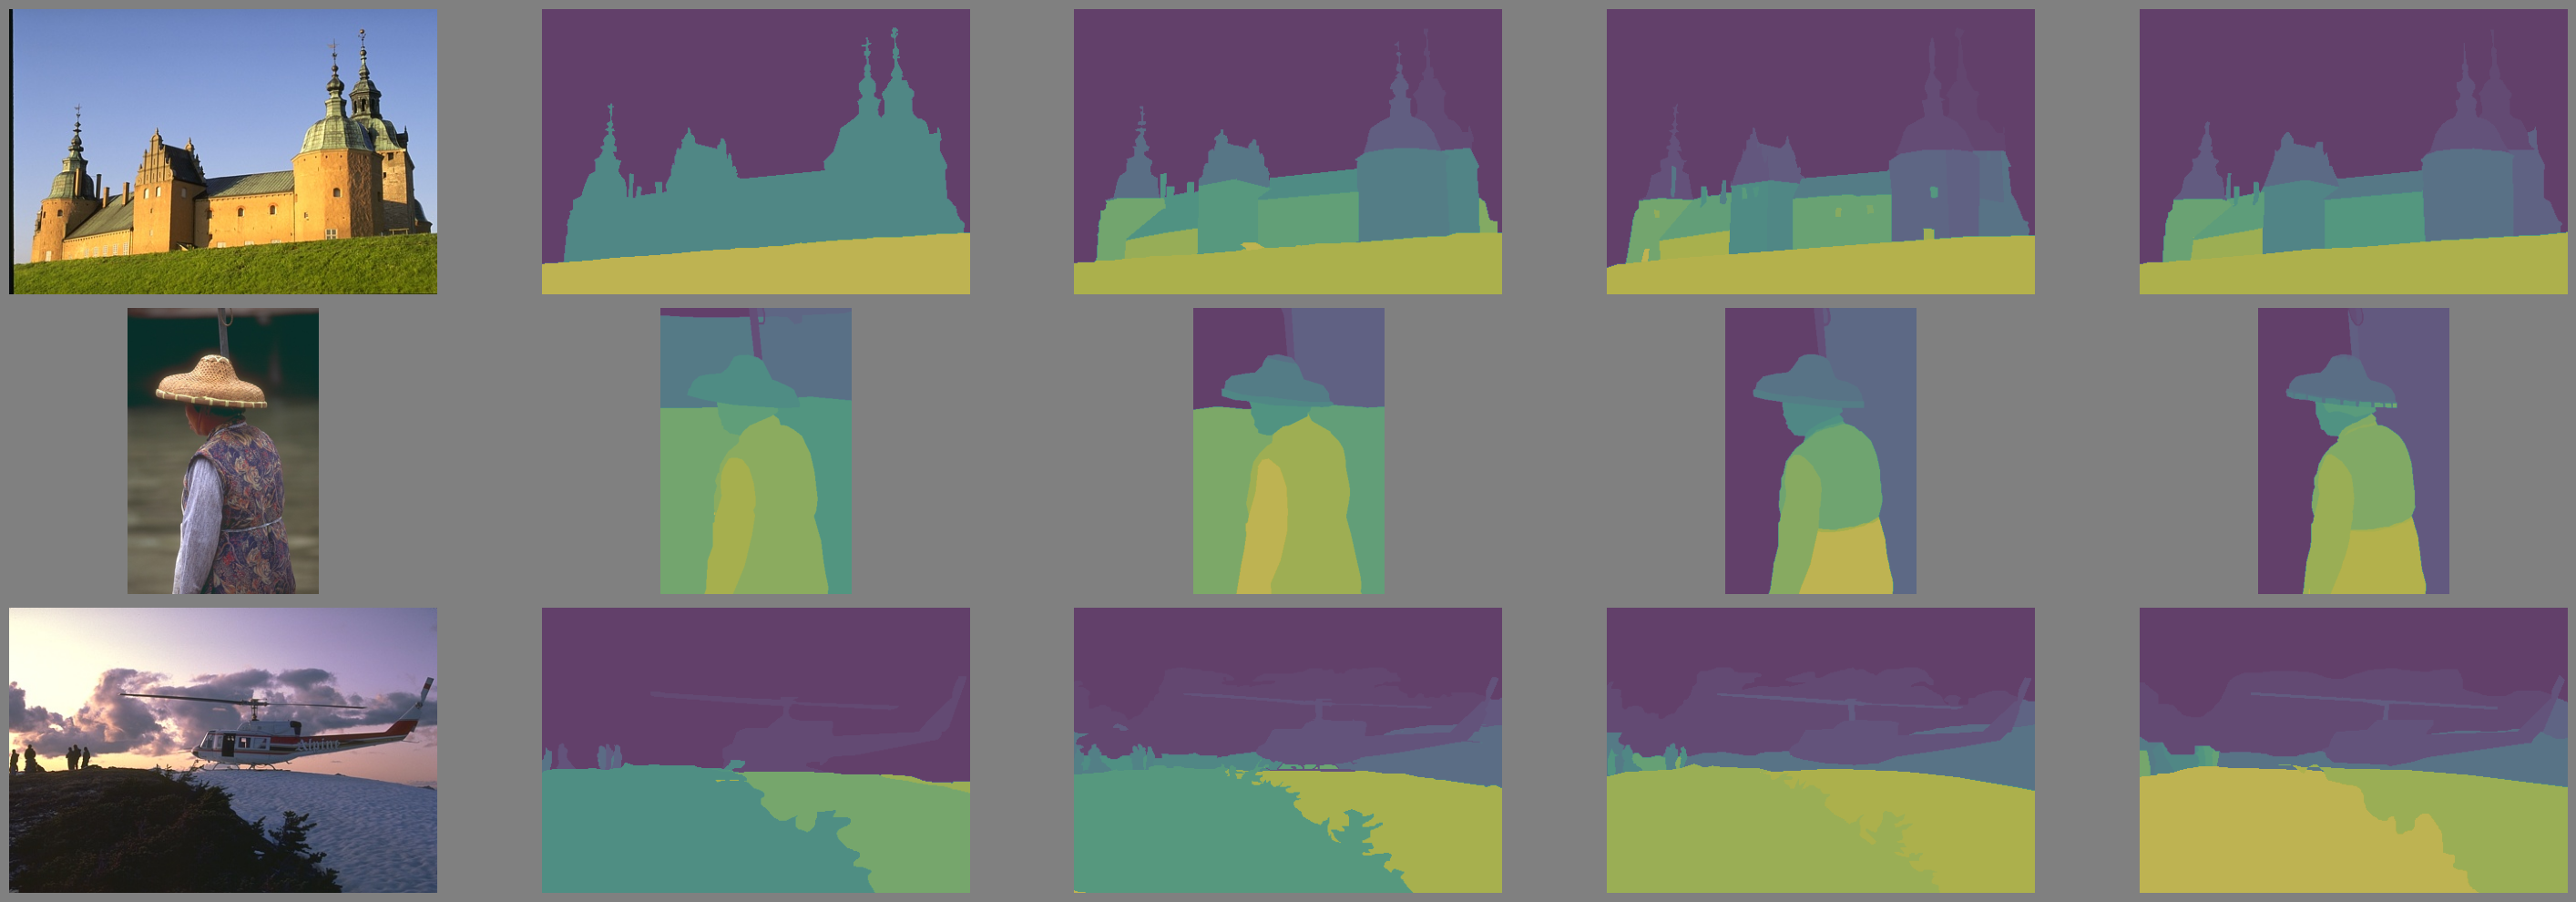

In [4]:
# plot image
rows = 3
cols = 5

fig, ax = plt.subplots(rows, cols, figsize = (30,10))
fig.patch.set_facecolor('grey')
# fig.subplots_adjust(vspace=.5)

for i in range(rows):
    ind = np.random.randint(0, 50)
    img = images[ind]
    # truth = ground_truths[ind]
    
    ax[i][0].imshow(img, cmap="gray")
    ax[i][0].axis("off")
    
    for j in range(1, cols):
        ax[i][j].imshow(ground_truths[j][ind], alpha=0.5)
        ax[i][j].axis("off")    
    

plt.tight_layout()

# 

# mk

In [5]:
colors = [
    (255, 0, 0),       # Red
    (0, 255, 0),       # Green
    (0, 0, 255),       # Blue
    (255, 255, 0),     # Yellow
    (128, 0, 128),     # Purple
    (255, 165, 0),     # Orange
    (0, 255, 255),     # Cyan
    (255, 182, 193),   # Pink
    (0, 255, 0),       # Lime
    (0, 128, 128),     # Teal
    (255, 215, 0)      # Gold
]

In [6]:
from sklearn.cluster import KMeans
def k_means_segmentation(image, k):
    image_np = np.array(image)
    pixels = image_np.reshape((-1, 3))

    # Apply K-means clustering with explicit n_init
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(pixels)
    

    return kmeans.labels_.reshape(image_np.shape[:2])

In [7]:
k_means_segmentation(images[0], 5)

array([[3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       ...,
       [3, 3, 3, ..., 4, 4, 4],
       [3, 3, 3, ..., 4, 4, 4],
       [3, 3, 3, ..., 3, 3, 3]], dtype=int32)

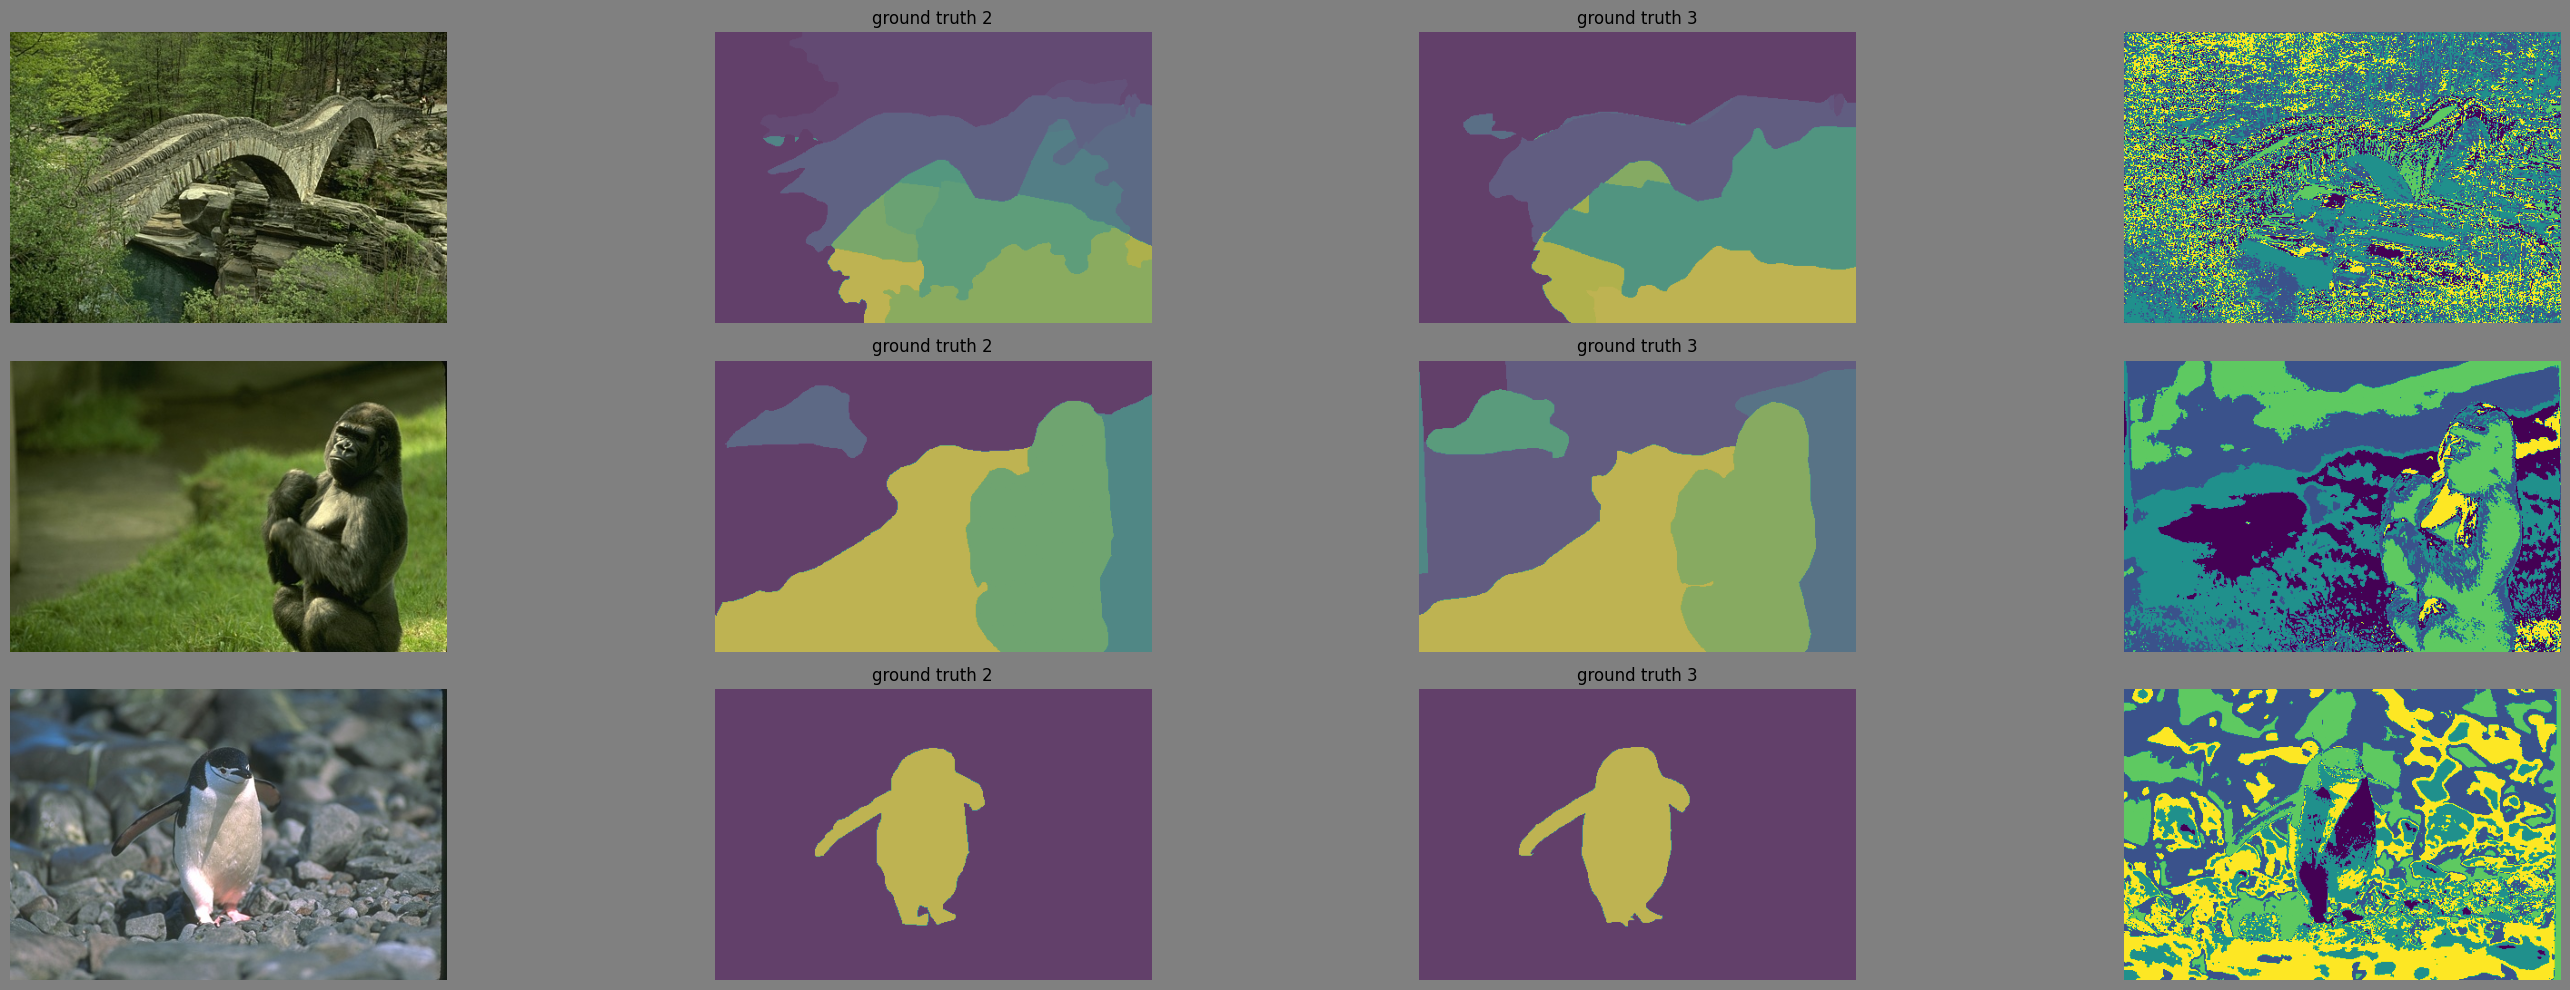

In [8]:
rows = 3
cols = 4

fig, ax = plt.subplots(rows, cols, figsize = (30,10))
fig.patch.set_facecolor('grey')
# fig.subplots_adjust(vspace=.5)

for i in range(rows):
    ind = np.random.randint(0, 50)
    img = images[ind]
    # truth = ground_truths[ind]
    
    ax[i][0].imshow(img, cmap="gray")
    ax[i][0].axis("off")
    
    for j in range(1, cols-1):
        ax[i][j].imshow(ground_truths[j][ind], alpha=0.5)
        ax[i][j].axis("off")  
        ax[i][j].set_title("ground truth " + str(j+1))
    
    ax[i][cols-1].imshow(k_means_segmentation(img, 5))
    ax[i][cols-1].axis("off")
    

plt.tight_layout()


In [9]:
clustered_images = {
    3: [k_means_segmentation(img, 3) for img in images],
    5: [k_means_segmentation(img, 5) for img in images],
    7: [k_means_segmentation(img, 7) for img in images],
    9: [k_means_segmentation(img, 9) for img in images],
    11: [k_means_segmentation(img, 11) for img in images],
}

In [10]:
def f_measure_evaluation(contingency_matrix):
    
    # turn to numpy array
    contingency_matrix = np.array(contingency_matrix)
    
    # calculate precision
    precision = np.max(contingency_matrix, axis=0)
    precision = precision / np.sum(contingency_matrix, axis=0)
    precision = np.mean(precision)
    
    # calculate recall
    recall = np.max(contingency_matrix, axis=1)
    recall = recall / np.sum(contingency_matrix, axis=1)
    recall = np.mean(recall)
    
    # calculate f measure
    f_measure = 2 * precision * recall / (precision + recall)
    
    return f_measure
    

In [11]:
def evaluate_clustered_images(clustered_images, ground_truths):
    f_measures = {}
    for k, clustered_images in clustered_images.items():
        f_measures[k] = []
        for clustered_image, ground_truth in zip(clustered_images, ground_truths):
            f_measures[k].append(f_measure_evaluation(ground_truth, clustered_image))
    return f_measures

In [12]:
from sklearn.metrics.cluster import contingency_matrix

def contingency_matrix_evaluation(ground_truth, clustered_image):
    # turn to numpy array
    ground_truth = np.array(ground_truth)
    clustered_image = np.array(clustered_image)
    
    # flatten
    ground_truth = ground_truth.flatten()
    clustered_image = clustered_image.flatten()
    
    return contingency_matrix(ground_truth, clustered_image)

In [13]:
def evaluate_clustered_images_contingency(clustered_images, ground_truths):
    contingency_matrices = {}
    for k, cimgs in clustered_images.items():
        contingency_matrices[k] = []
        for clustered_image, ground_truth in zip(cimgs, ground_truths):
            a1 = np.array(ground_truth)
            a2 = np.array(clustered_image)
            contingency_matrices[k].append(contingency_matrix_evaluation(ground_truth, clustered_image))
    return contingency_matrices

In [14]:
contingency_matrices_per_ground_truth = []

for i in range(len(ground_truths)):
    contingency_matrices_per_ground_truth.append(evaluate_clustered_images_contingency(clustered_images, ground_truths[i]))


In [15]:
def conditional_entropy(mat):
    mat = np.array(mat)
    mat = mat / np.sum(mat)
    mat = mat + 1e-10
    mat = mat / np.sum(mat)
    mat = mat * np.log(mat)
    return -np.sum(mat)

In [16]:
def evaluation_report(contingency_matrices_per_ground_truths):
    report = {}
    
    # for every type of ground truth
    for i in range(len(contingency_matrices_per_ground_truths)):
        print("---------------------")
        print("| Ground truth: ", i, " |")
        print("---------------------")

        report[i] = []
        
        # for every K used to cluster
        for k, contingency_matrices in contingency_matrices_per_ground_truths[i].items():
            print("K: ", k)
        
            entropy_sum = 0
            f_measure_sum = 0
            
            # for every image
            for j, contingency_matrix in enumerate(contingency_matrices):
                
                entropy_sum += conditional_entropy(contingency_matrix)
                f_measure_sum += f_measure_evaluation(contingency_matrix)
                
            print("Avg Entropy: ", entropy_sum / len(contingency_matrices))
            print("Avg F measure: ", f_measure_sum / len(contingency_matrices))
            print("--------------------------------------------------")
            

In [17]:
evaluation_report(contingency_matrices_per_ground_truth)

---------------------
| Ground truth:  0  |
---------------------
K:  3
Avg Entropy:  2.2629699241863794
Avg F measure:  0.6204786385665035
--------------------------------------------------
K:  5
Avg Entropy:  2.67610114587947
Avg F measure:  0.5765048854729347
--------------------------------------------------
K:  7
Avg Entropy:  2.921505282814639
Avg F measure:  0.5533922362622163
--------------------------------------------------
K:  9
Avg Entropy:  3.123039010664752
Avg F measure:  0.5312411999142129
--------------------------------------------------
K:  11
Avg Entropy:  3.2679453445698043
Avg F measure:  0.5137592426232869
--------------------------------------------------
---------------------
| Ground truth:  1  |
---------------------
K:  3
Avg Entropy:  2.327487468459998
Avg F measure:  0.6082706675726776
--------------------------------------------------
K:  5
Avg Entropy:  2.7432158687104167
Avg F measure:  0.5753076580090655
------------------------------------------------

In [18]:
contingency_matrices_per_ground_truth[4][3]

[array([[80371,  1655,    59],
        [  238,  1949,   592],
        [  264,  1751,  1466],
        [  183,  1459,   571],
        [   64,  2520,  1411],
        [  118,  1768,  1081],
        [   24,  3911,  6049],
        [   18,  1519,   760],
        [   13,   115,     0],
        [   15,  2208,  3193],
        [    3,    71,    67],
        [    7,    55,    52],
        [    0,  1189,  5092],
        [   12,  1613,   484],
        [    9,  1180,  1942],
        [    0,     1,     0],
        [    0,     1,     0],
        [    0,   114,  1886],
        [   24, 24987,   266],
        [    0,     0,     1]]),
 array([[    1, 30407, 11129],
        [  198,  6544, 20246],
        [ 4086,   195,  3737],
        [  438,    57,   508],
        [   23,     0,   868],
        [    1,   144,    51],
        [  156,  3828,  4480],
        [   19,   330,    31],
        [  393,    50,    32],
        [   29,   459,   124],
        [    0,     0,     6],
        [  140,     3,    32],
      

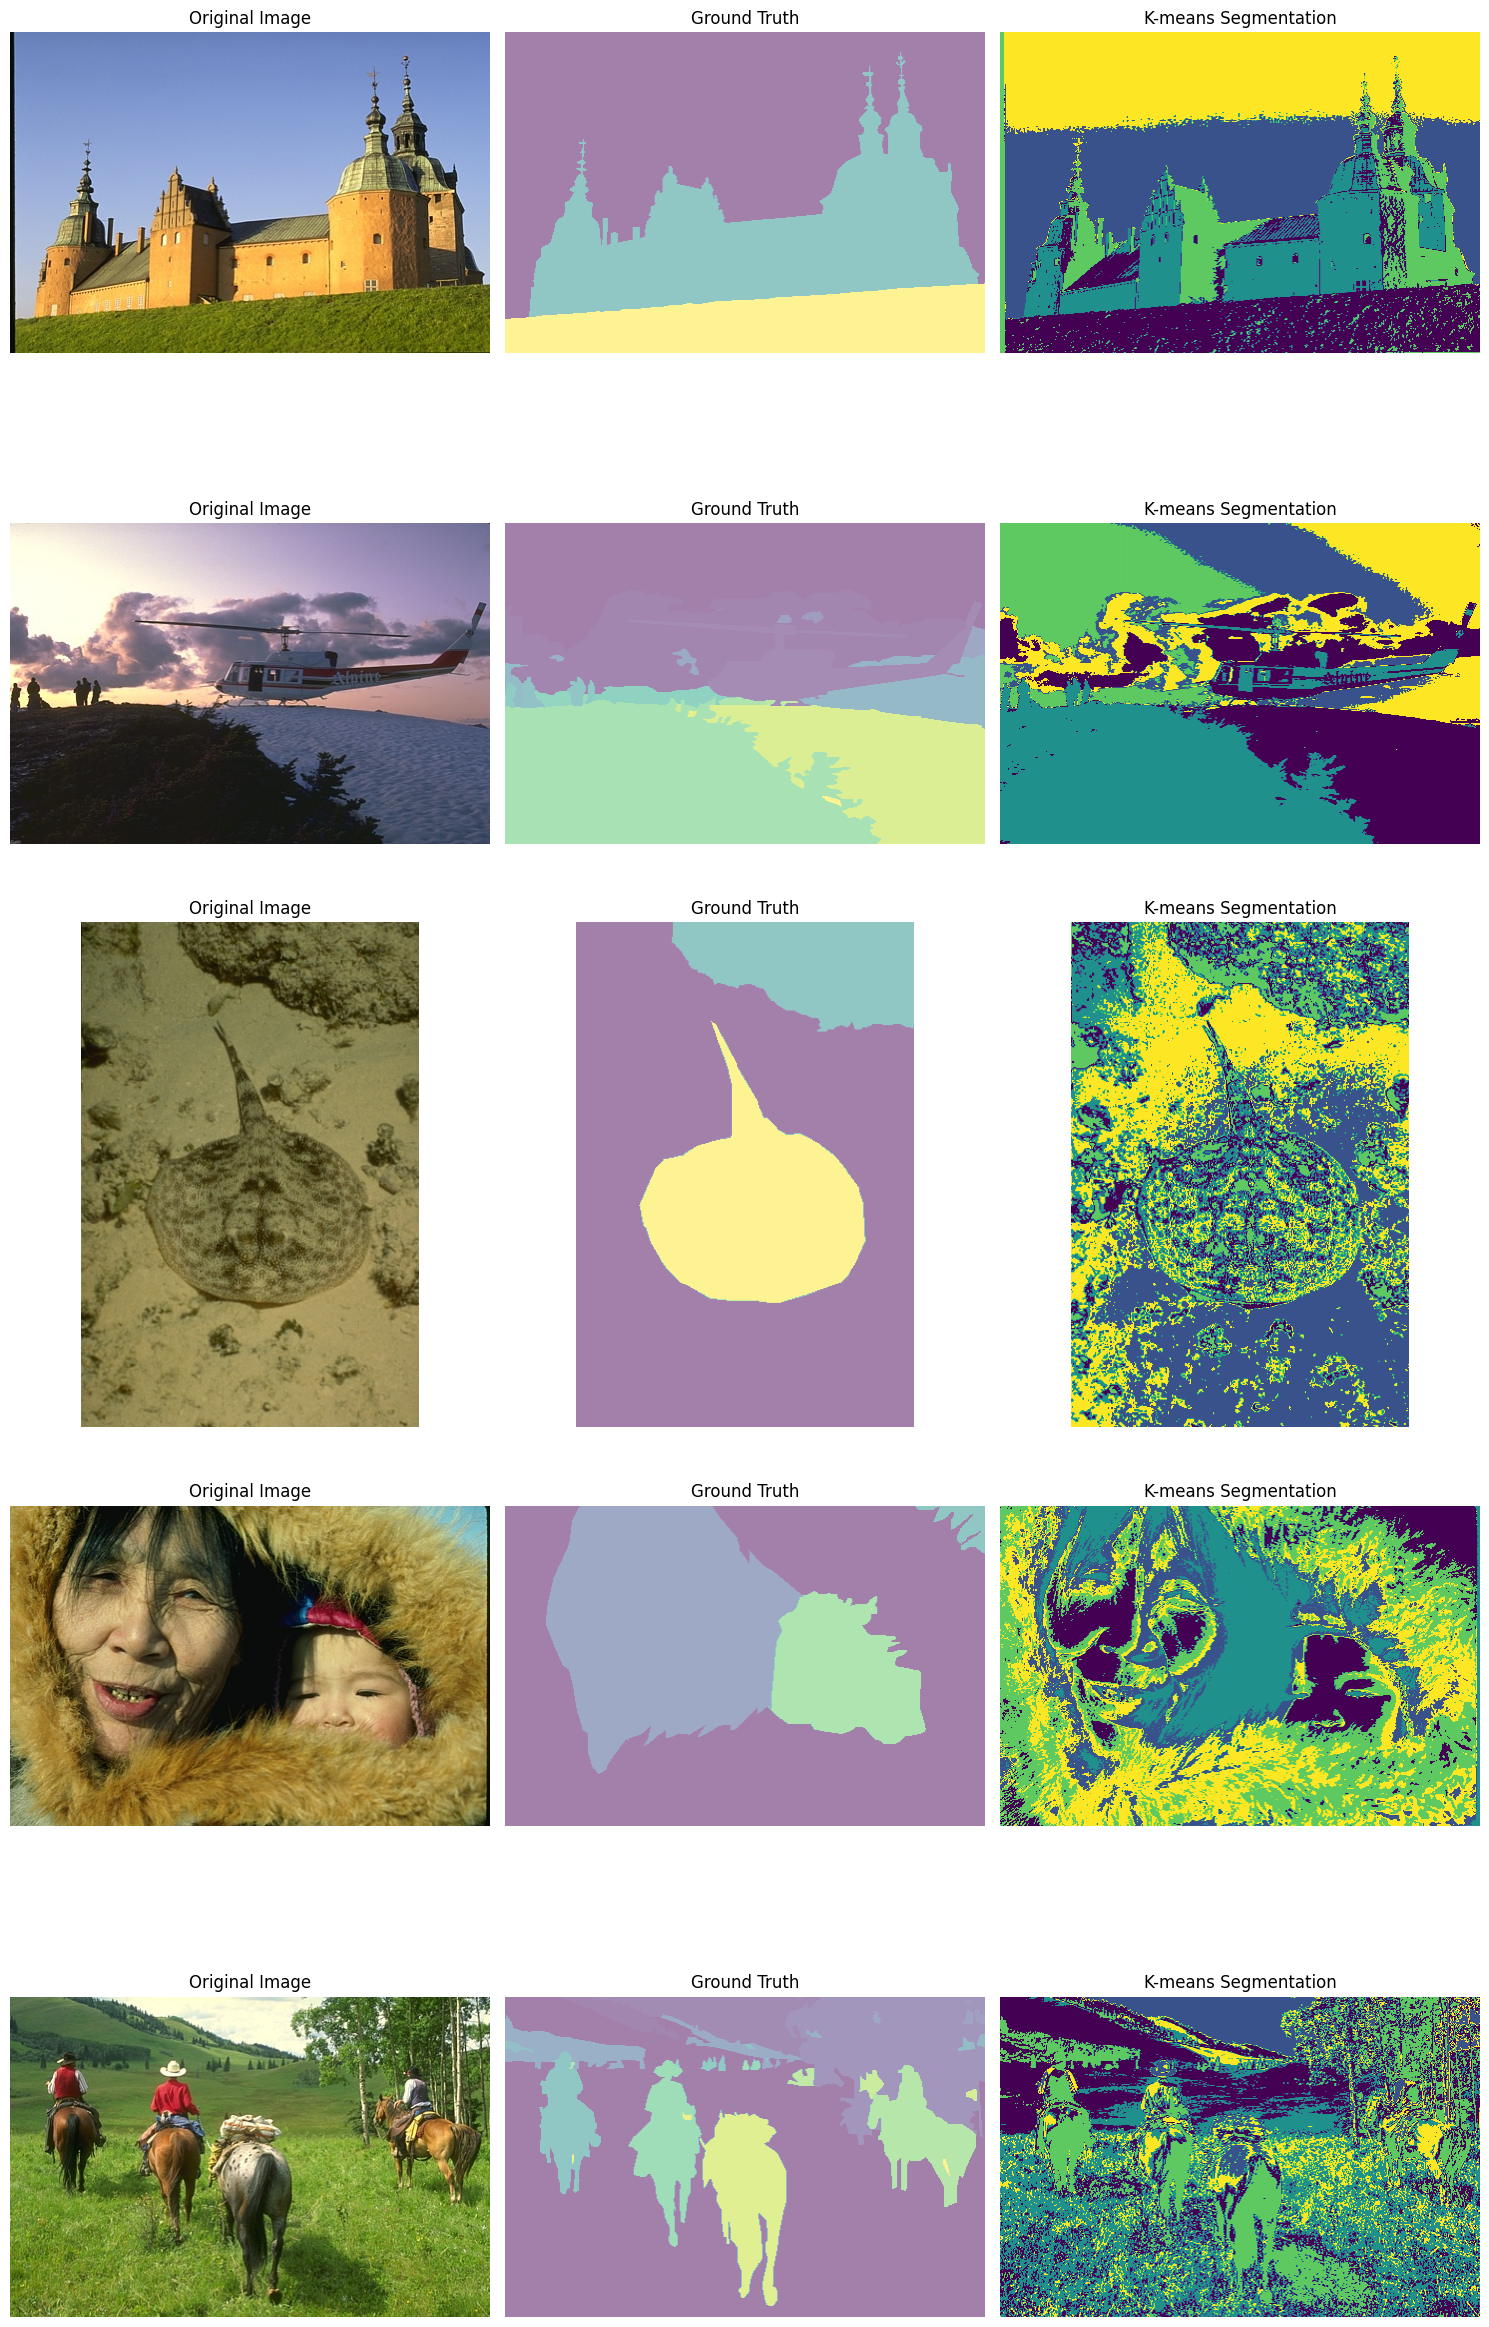

In [19]:
# Select five images
selected_images = images[:5]
selected_ground_truths = {k: v[:5] for k, v in ground_truths.items()}

# Apply K-means segmentation
kmeans_segmented_images = [k_means_segmentation(img, 5) for img in selected_images]

# Display the images, ground truths, and segmentation results
fig, ax = plt.subplots(5, 3, figsize=(15, 25))

for i in range(5):
    # Original image
    ax[i, 0].imshow(selected_images[i], cmap="gray")
    ax[i, 0].set_title("Original Image")
    ax[i, 0].axis("off")

    # Ground truth
    ax[i, 1].imshow(selected_ground_truths[0][i], alpha=0.5)
    ax[i, 1].set_title("Ground Truth")
    ax[i, 1].axis("off")

    # K-means segmentation
    ax[i, 2].imshow(kmeans_segmented_images[i])
    ax[i, 2].set_title("K-means Segmentation")
    ax[i, 2].axis("off")

plt.tight_layout()
plt.show()

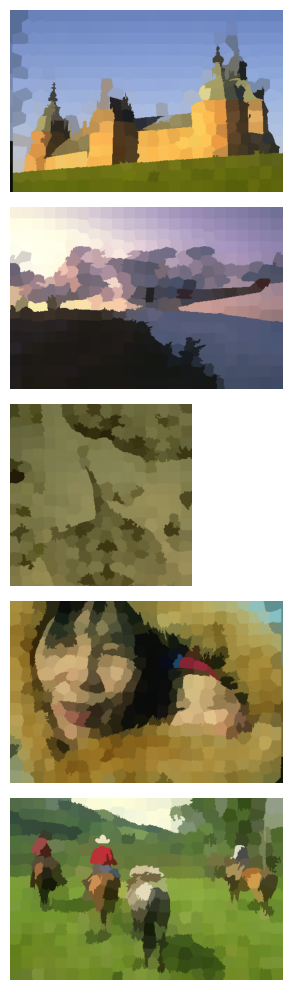

In [20]:
from skimage import data, segmentation, color
from skimage import graph
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=5, sharex=True, sharey=True, figsize=(10, 10))

for i, img in enumerate(selected_images):
    labels1 = segmentation.slic(img, compactness=30, n_segments=400,
                                start_label=1)
    out1 = color.label2rgb(labels1, img, kind='avg', bg_label=0)
    
    g = graph.rag_mean_color(img, labels1, mode='similarity')
    labels2 = graph.cut_normalized(labels1, g)
    out2 = color.label2rgb(labels2, img, kind='avg', bg_label=0)
    
    
    ax[i].imshow(out1)
    ax[i].axis('off')


plt.tight_layout()

In [21]:

img = clustered_images[3][0]
labels1 = segmentation.slic(img, compactness=30, n_segments=400,
                                start_label=1)
out1 = color.label2rgb(labels1, img, kind='avg', bg_label=0)

g = graph.rag_mean_color(img, labels1, mode='similarity')
labels2 = graph.cut_normalized(labels1, g)
out2 = color.label2rgb(labels2, img, kind='avg', bg_label=0)


ax[i].imshow(out1)
ax[i].axis('off')

ValueError: channel_axis=-1 indicates multichannel, which is not supported for a two-dimensional image; use channel_axis=None if the image is grayscale